In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time, os.path, datetime
from alpha_vantage.timeseries import TimeSeries
ts = TimeSeries(key='B53N03ODVZVOH8R3',output_format='pandas')
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler

In [2]:
# abbr = 'TGT'
skipTrain = True
now = datetime.datetime.now()
todayEight = now.replace(hour=8, minute=0, second=0, microsecond=0)
# modelName = "tgtModel.h5"

In [3]:
def getData(abbr):
    name = str('csvs/' + abbr + '_data.csv')
    lastUpdate = datetime.datetime.fromtimestamp(time.mktime(time.gmtime(os.path.getmtime(name))))
    
    if (lastUpdate > todayEight) == True:
        print("yay")
        data = pd.read_csv(name)
        data = data.iloc[::-1]
    else:
        data, metadata=ts.get_daily(abbr,outputsize='full')
        data = data.iloc[::-1]
        data.to_csv(name)
        
    data['date'] = data.index
    return data, name, abbr

In [4]:
def loadScale(name):
    training_complete = pd.read_csv(name)
    training_processed = training_complete.iloc[:, 1:2].values
    scaler = MinMaxScaler(feature_range = (0, 1))
    training_scaled = scaler.fit_transform(training_processed)
    return training_complete, training_processed, scaler, training_scaled

In [5]:
def trainModel(training_scaled, abbr):
    if skipTrain == True:
        model = load_model(modelName)
    elif skipTrain == False:
        features_set = []
        labels = []
        end = len(training_scaled)-1
        for i in range(60, end):
            features_set.append(training_scaled[i-60:i, 0])
            labels.append(training_scaled[i, 0])

        # Convert both the feature_set and the labels list to the numpy array before we can use it for training
        features_set, labels = np.array(features_set), np.array(labels)

        # In order to train LSTM on our data, we need to convert our data into the shape accepted by the LSTM.
        # We need to convert our data into three-dimensional format
        features_set = np.reshape(features_set, (features_set.shape[0], features_set.shape[1], 1))

        model = Sequential()
        model.add(LSTM(units=50, return_sequences=True, input_shape=(features_set.shape[1], 1)))

        # Add dropout layer to avoid overfitting of the data
        model.add(Dropout(0.2))
        model.add(LSTM(units=50, return_sequences=True))
        model.add(Dropout(0.2))

        model.add(LSTM(units=50, return_sequences=True))
        model.add(Dropout(0.2))

        model.add(LSTM(units=50))
        model.add(Dropout(0.2))

        # To make our model more robust we add a dense layer
        model.add(Dense(units = 1))

        model.compile(optimizer = 'adam', loss = 'mean_squared_error')
        
        print(abbr)

        # Train the model

        model.fit(features_set, labels, epochs = 100, batch_size = 32)
        
        # Save Model
        modelTarget = str('models/' + abbr + 'Model.h5')
        model.save(modelTarget)

#     # Pull in recent stock data to test the prediction model against - last 100 days of data
#     data2, metadata=ts.get_daily(abbr,outputsize='compact')
#     name = str('csvs/' + abbr + '_data_2.csv')
#     data2.to_csv(name)
    
    name = str('csvs/' + abbr + '_data_2.csv')
    lastUpdate = datetime.datetime.fromtimestamp(time.mktime(time.gmtime(os.path.getmtime(name))))
    
    if (lastUpdate > todayEight) == True:
        data = pd.read_csv(name)
    else:
        data2, metadata=ts.get_daily(abbr,outputsize='compact')
        data2 = data2.iloc[::-1]
        data2.to_csv(name)

    return model, name

In [6]:
def predict(name, scaler, abbr, model, training_complete):
    testing_complete = pd.read_csv(name)
    name = str('pet_pals/static/assets/img/' + abbr + '_predictions.png')
    testing_processed = testing_complete.iloc[:, 1:2].values
    total = pd.concat((training_complete['1. open'], testing_complete['1. open']), axis=0)
    test_inputs = total[len(total) - len(testing_complete) - 60:].values
    test_inputs = test_inputs.reshape(-1,1)
    testii = test_inputs
    test_inputs = scaler.transform(test_inputs)
    testy = scaler.inverse_transform(test_inputs)
    test_features = []
    
    for i in range(60, 161):
        test_features.append(test_inputs[i-60:i, 0])
    test_features = np.array(test_features)
    test_features = np.reshape(test_features, (test_features.shape[0], test_features.shape[1], 1))
    predictions = model.predict(test_features)

    for i in range(0,10):
        new_pred = [predictions[-1]]
        test_inputs = np.append(test_inputs,new_pred)
        test_features = []
        for j in range(60, 161+i):
            test_features.append(test_inputs[j-60:j])
        test_features = np.array(test_features)
        test_features = np.reshape(test_features, (test_features.shape[0], test_features.shape[1], 1))
        predictions = model.predict(test_features)

    predictions = scaler.inverse_transform(predictions)
    
    predname = str("csvs/" + abbr + "_prediction.csv")
    np.savetxt(predname, predictions, delimiter=",")
    print(predictions.shape)
    print(test_inputs.shape)
    print(predictions[-10::])
    
    # Plot the results -model trained with 100 epochs 
    plt.figure(figsize=(10,6))
    plt.plot(testing_processed, color='blue', label='Actual Stock Price')
    plt.plot(predictions , color='red', label='Predicted Stock Price')
    plt.title(abbr + ' Stock Price Prediction')
    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.savefig(name)
    plt.show()
    

In [7]:
def runModel(abbr):
    data, name, abbr = getData(abbr)
    training_complete, training_processed, scaler, training_scaled = loadScale(name)
    model, name = trainModel(training_scaled, abbr)
    predict(name, scaler, abbr, model, training_complete)

MSFT
yay
(110, 1)
(170,)
[[210.50174]
 [211.56122]
 [212.55133]
 [213.36429]
 [214.16843]
 [214.83499]
 [215.49422]
 [216.09967]
 [216.67198]
 [217.20932]]


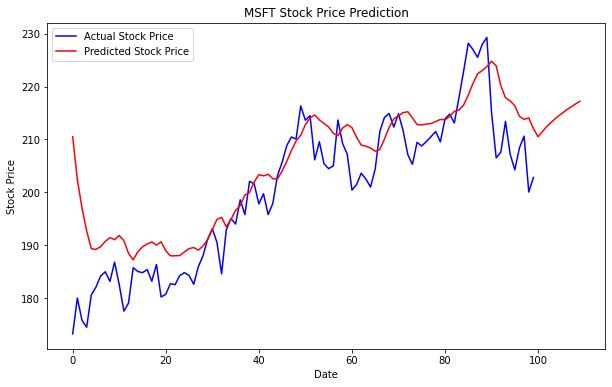

AAPL
yay
(110, 1)
(170,)
[[112.42881 ]
 [112.6934  ]
 [113.99962 ]
 [115.71863 ]
 [117.71843 ]
 [119.91447 ]
 [122.216644]
 [124.555565]
 [126.886696]
 [129.18565 ]]


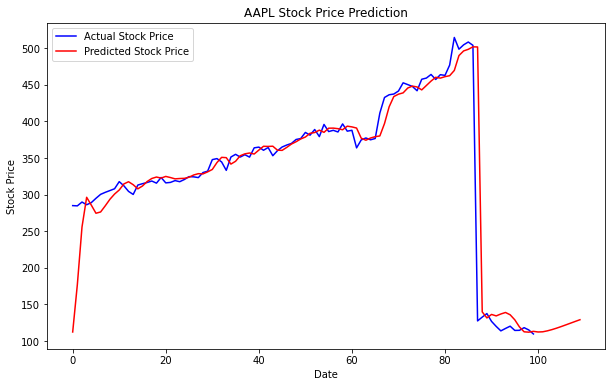

AMZN
yay
(110, 1)
(170,)
[[3140.3296]
 [3127.9478]
 [3126.824 ]
 [3124.0718]
 [3122.352 ]
 [3118.3582]
 [3113.1592]
 [3106.6748]
 [3099.4473]
 [3091.6782]]


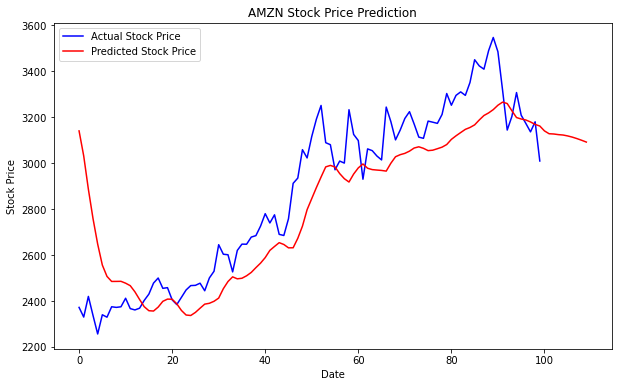

FB
yay
(110, 1)
(170,)
[[262.65277]
 [259.90936]
 [259.9505 ]
 [259.9536 ]
 [259.59772]
 [259.0842 ]
 [258.48895]
 [257.8429 ]
 [257.1731 ]
 [256.50067]]


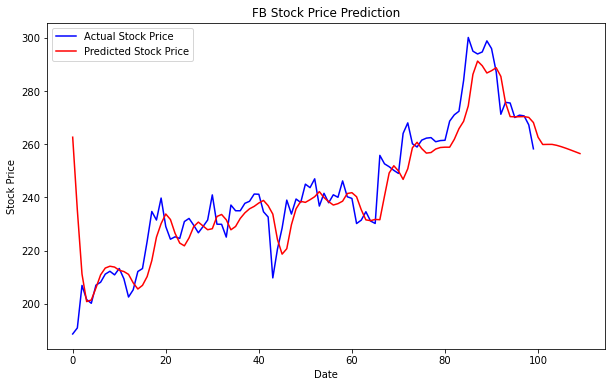

BRK-B
yay
(110, 1)
(170,)
[[142.18607 ]
 [138.22585 ]
 [134.32481 ]
 [131.58737 ]
 [129.84045 ]
 [128.68086 ]
 [127.773155]
 [126.9214  ]
 [126.065216]
 [125.226456]]


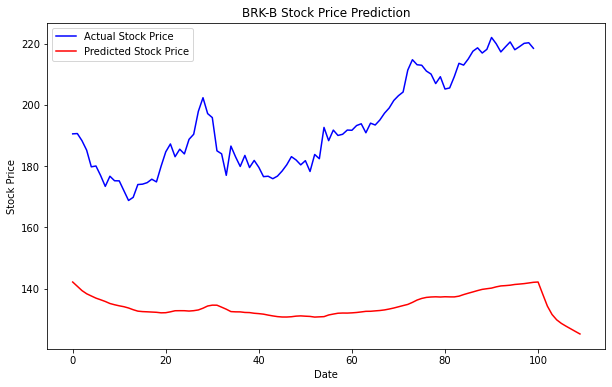

GOOGL
yay
(110, 1)
(170,)
[[1469.9578]
 [1449.591 ]
 [1444.2595]
 [1432.4175]
 [1423.1393]
 [1413.2236]
 [1404.1692]
 [1395.366 ]
 [1387.0142]
 [1378.9706]]


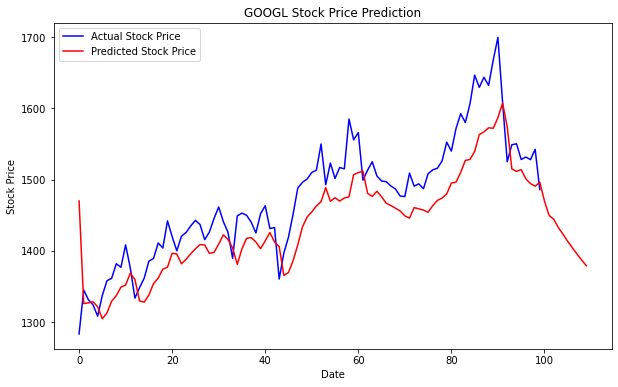

JNJ
yay
(110, 1)
(170,)
[[145.87332]
 [144.92863]
 [144.51971]
 [144.03142]
 [143.38843]
 [142.77904]
 [142.16846]
 [141.54904]
 [140.93202]
 [140.32104]]


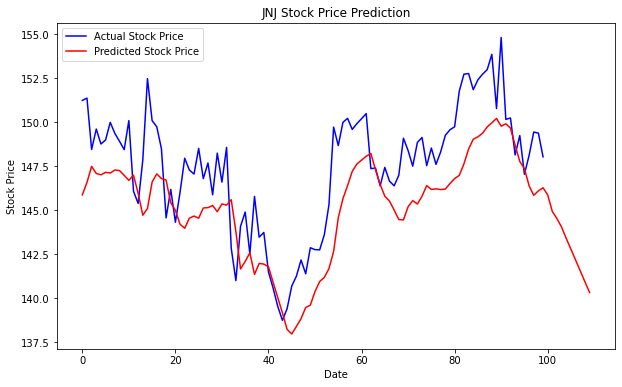

JPM
yay
(110, 1)
(170,)
[[101.04451 ]
 [102.21761 ]
 [102.56197 ]
 [103.48236 ]
 [104.040726]
 [104.879814]
 [105.54919 ]
 [106.336266]
 [107.02619 ]
 [107.7475  ]]


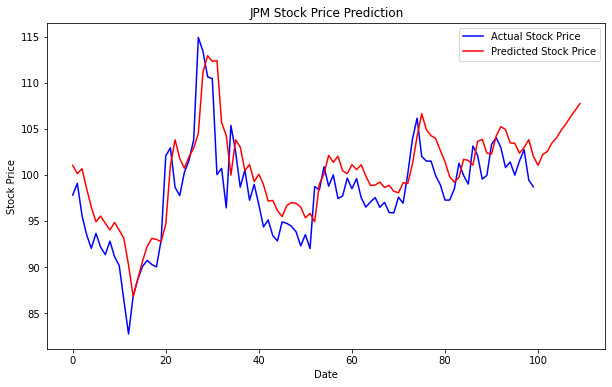

V
yay
(110, 1)
(170,)
[[205.91945]
 [206.02492]
 [206.4958 ]
 [206.86769]
 [207.23778]
 [207.61217]
 [207.98563]
 [208.35777]
 [208.72775]
 [209.09439]]


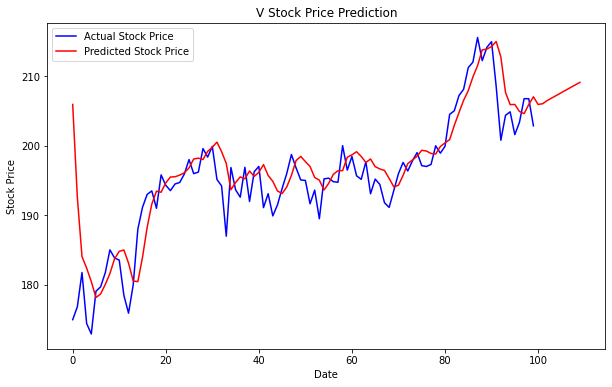

PG
yay
(110, 1)
(170,)
[[137.16931]
 [137.26688]
 [137.33441]
 [137.22432]
 [137.1518 ]
 [137.08606]
 [137.02882]
 [136.97253]
 [136.91933]
 [136.86769]]


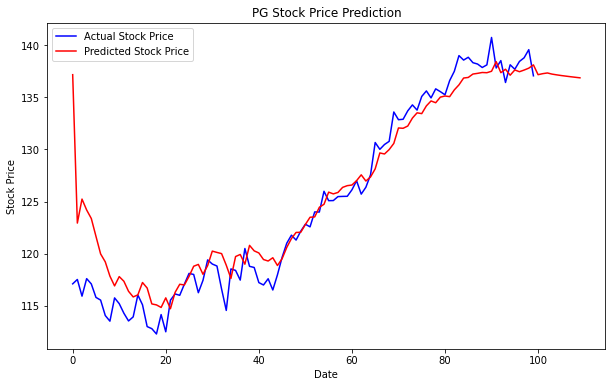

MA
yay
(110, 1)
(170,)
[[343.34338]
 [344.0734 ]
 [345.33496]
 [346.40118]
 [347.40594]
 [348.42105]
 [349.44083]
 [350.4658 ]
 [351.50018]
 [352.5454 ]]


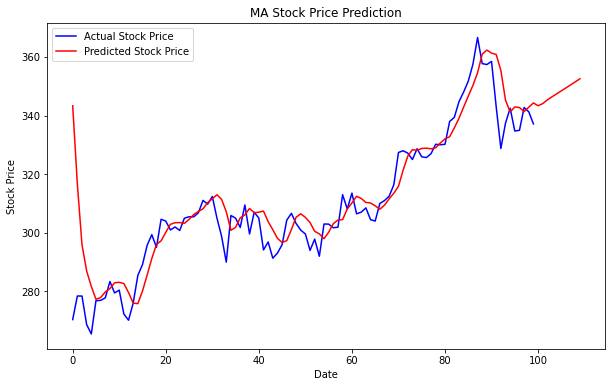

INTC
yay
(110, 1)
(170,)
[[47.254223]
 [45.463726]
 [44.69623 ]
 [43.4011  ]
 [42.396618]
 [41.26968 ]
 [40.235165]
 [39.187687]
 [38.18048 ]
 [37.187523]]


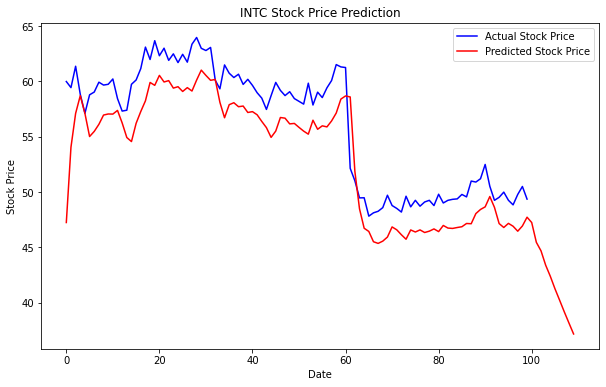

UNH
yay
(110, 1)
(170,)
[[302.2945 ]
 [300.61526]
 [299.71246]
 [298.55713]
 [297.21124]
 [295.8705 ]
 [294.48166]
 [293.05707]
 [291.59787]
 [290.1016 ]]


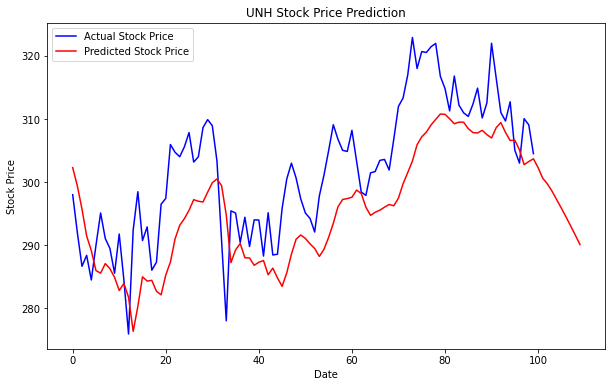

BAC
yay
(110, 1)
(170,)
[[25.626852]
 [25.861366]
 [26.055996]
 [26.239632]
 [26.410048]
 [26.567465]
 [26.713459]
 [26.851767]
 [26.985914]
 [27.119108]]


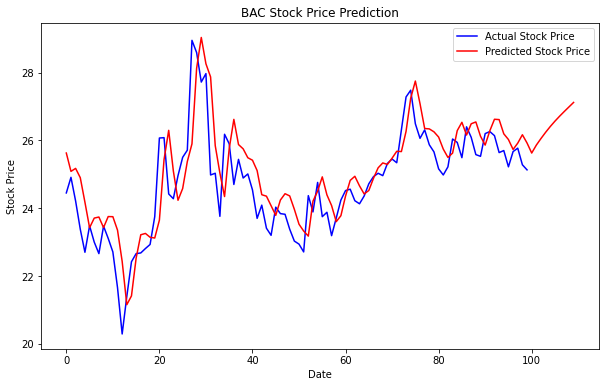

T
yay
(110, 1)
(170,)
[[29.22612 ]
 [29.2828  ]
 [29.282059]
 [29.329418]
 [29.329777]
 [29.371939]
 [29.375761]
 [29.415558]
 [29.423622]
 [29.462234]]


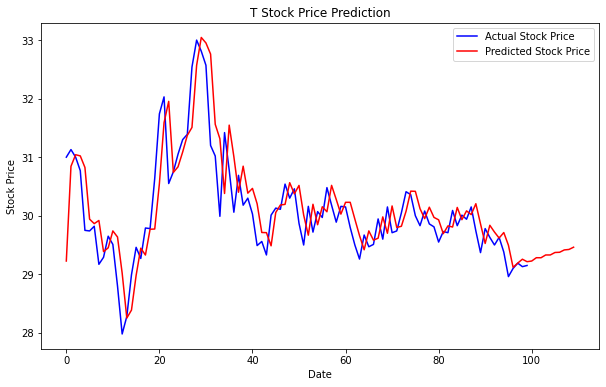

In [8]:
# comps = ["AAPL","GE","GOOGL","IBM","JPM","SBUX","TGT","UAL"]
comps = ["MSFT","AAPL","AMZN","FB","BRK-B","GOOGL","JNJ","JPM","V","PG","MA","INTC","UNH","BAC","T"]
# comps = ["MSFT"]
for entry in comps:
    print(entry)
    low = entry.lower()
    modelName = str('models/' + low + 'Model.h5')
    runModel(entry)
    name = str('csvs/' + entry + '_data_2.csv')
    lastUpdate = datetime.datetime.fromtimestamp(time.mktime(time.gmtime(os.path.getmtime(name))))
    if (lastUpdate < todayEight):
        time.sleep(26)